In [1]:
# Exemplo Fine Tuning de uma VGG16
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import regularizers
from keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import matplotlib.style as sty

from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

import os
import random as rn
import seaborn as sns

import tensorflow as tf
import cv2


In [2]:
#Configurações Arbritarias escolhidas para treinamento
batch_size = 64
num_classes = 10
epochs = 10
W=64
H=64


In [3]:
# load train and test dataset (CIFAR 10)
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # pegando apenas parte das imagens de treinamento devido ao limite de nossa memória
    #Xtr, Xvl, ytr, yvl = train_test_split(trainX, trainY, test_size=.0,random_state=42,stratify=trainY)
    Xtr=trainX
    ytr=trainY
    # one hot encode target values
    nb_train_samples = len(Xtr)
    nb_test_samples = len(testX)
    print(nb_train_samples)
    trainX = np.array([cv2.resize(img, (W,H)) for img in Xtr[:nb_train_samples,:,:,:]])
    testX = np.array([cv2.resize(img, (W,H)) for img in testX[:nb_test_samples,:,:,:]])
    trainY = to_categorical(ytr)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [4]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [5]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
print(trainX.shape)
print(testX.shape)
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)

170498071/170498071 [==============================] - 13s 0us/step
50000
(50000, 64, 64, 3)
(10000, 64, 64, 3)


In [8]:
# Load VGG16 without the top FC Layers.
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import VGG16

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(W, H, 3))

vgg_conv.summary()

# Fine Tunning VGG16 
# Create 'model' from vgg_conv adding dense layers and reducing the number of classes to 10

model = Sequential()
model.add(vgg_conv)
model.add(Flatten()) #GlobalAvgPooling()
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

# Freeze the layers except the last 4 layers
for layer in model.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

model.summary()


58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [9]:
# Compilar a CNN
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'] )


In [ ]:
# Imprimir a topologia
model.summary()

In [11]:
# Treinar a CNN
#es=EarlyStopping(monitor='val_loss', mode='min', verbose=1)

fp='/content/checkpoints/bestmodel.hdf5'
#fp='/content/checkpoints/cp-{epoch:02d}.hdf5'
mc = tf.keras.callbacks.ModelCheckpoint(
#    filepath='/content/checkpoints/cp-{epoch:02d}.hdf5',
    filepath=fp,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)
results=model.fit(trainX, trainY,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_split=0.2,
                  callbacks=[mc])

# Os pesos do melhor modelo são carregados
model.load_weights(fp)

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 1.1800 - accuracy: 0.5866
Epoch 1: val_accuracy improved from -inf to 0.66210, saving model to /content/checkpoints/bestmodel.hdf5
625/625 [==============================] - 33s 35ms/step - loss: 1.1800 - accuracy: 0.5866 - val_loss: 0.9641 - val_accuracy: 0.6621
Epoch 2/10
624/625 [============================>.] - ETA: 0s - loss: 0.9552 - accuracy: 0.6662
Epoch 2: val_accuracy improved from 0.66210 to 0.68510, saving model to /content/checkpoints/bestmodel.hdf5
625/625 [==============================] - 21s 34ms/step - loss: 0.9555 - accuracy: 0.6661 - val_loss: 0.9109 - val_accuracy: 0.6851
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.8668 - accuracy: 0.6974
Epoch 3: val_accuracy improved from 0.68510 to 0.68780, saving model to /content/checkpoints/bestmodel.hdf5
625/625 [==============================] - 21s 33ms/step - loss: 0.8668 - accuracy: 0.6974 - val_loss: 0.8922 - val_accuracy:

In [12]:
# Executar a avaliação (teste)
score=model.evaluate(testX, testY, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.8584085702896118
Test accuracy:  0.7046999931335449


<ipython-input-13-9c068e78964d>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  sty.use('seaborn-whitegrid')


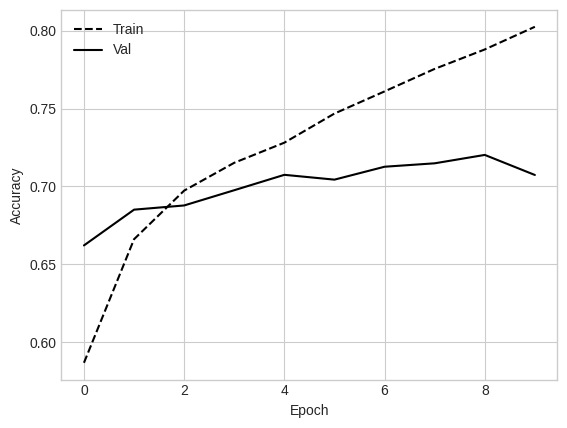

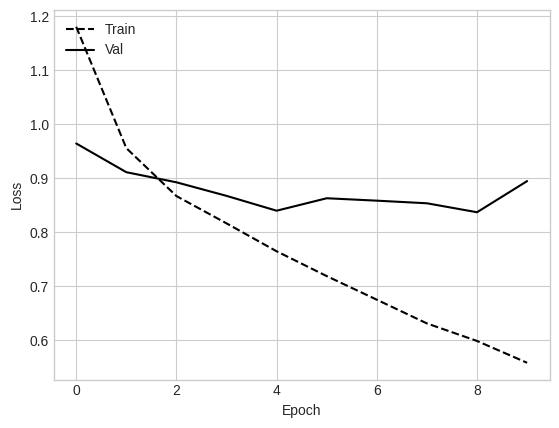

In [13]:
# Plotar o grafico do histórico de evolução do treinamento
sty.use('seaborn-whitegrid')
plt.plot(results.history['accuracy'],'k--')
plt.plot(results.history['val_accuracy'],'k')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plota o grafico do histórico de evolução da taxa de perda da rede 
plt.plot(results.history['loss'],'k--')
plt.plot(results.history['val_loss'],'k')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [14]:
# Plotar a matrix de confusão 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation = 'nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  
  print(cm)
  
  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j, i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")
   
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [15]:
# Predição da CNN
y_predict=np.argmax(model.predict(testX), axis=1)

# Preparar Matriz de Confusão
cm=confusion_matrix(np.argmax(testY, axis=1), y_predict)

313/313 [==============================] - 4s 14ms/step


Confusion matrix, without normalization
[[767  18  59  20  36   6   6  18  49  21]
 [ 19 823   8  20   7  16  14  12  25  56]
 [ 35   8 649  56 117  34  61  35   3   2]
 [ 18  19  51 541  79 145  74  51   9  13]
 [ 16  11  44  58 716  24  38  81   7   5]
 [  9  13  50 180  62 575  34  66   3   8]
 [  7  16  58  65  99  42 695  11   5   2]
 [ 10   9  25  36  71  54  12 767   2  14]
 [ 68  46  19  20  21   8   5  10 778  25]
 [ 36 115   6  34  12  11   7  24  19 736]]


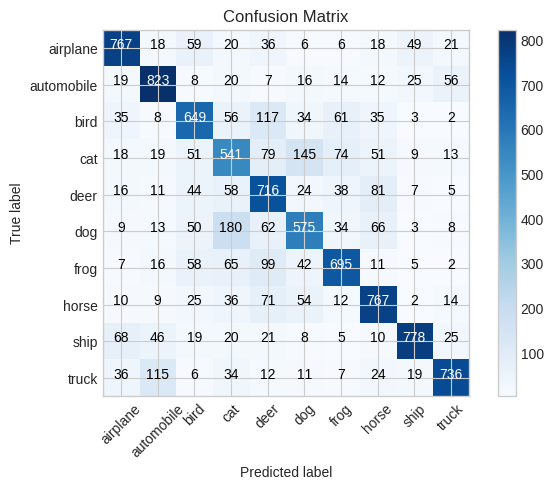

In [16]:
# Chamada da matriz confusão
cm_plot_labels=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cm, cm_plot_labels, title= 'Confusion Matrix')


In [17]:
# Salvando o modelo, a arquitetura da CNN
model_json = model.to_json()
with open("cnn.json", "w") as json_file:
  json_file.write(model_json)

# Salvando os pesos da CNN
model.save_weights("cnn_weights.h5")

In [18]:
# Exemplo de como carregar a usar modelo salvo.

from keras.models import model_from_json

# Carregando o modelo
json_file=open("cnn.json", "r")
cnn_json=json_file.read()
json_file.close()

cnn_model=model_from_json(cnn_json)

# Carregando os pesos
cnn_model.load_weights("cnn_weights.h5")

# Predição usando o modelo carregado
y_predict=np.argmax(cnn_model.predict(testX), axis=1)

y=np.argmax(testY, axis=1)

# Predição usando apenas uma imagem
exemplo=testX[2]
print(exemplo.shape)
exemplo = exemplo.reshape(1, W, H, 3)
saida=cnn_model.predict(exemplo)
classe=np.argmax(saida, axis=1)

y_test=np.argmax(testY[2], axis=0)
print(cm_plot_labels[classe[0]], 'expected:', cm_plot_labels[y_test] )


313/313 [==============================] - 4s 13ms/step
(64, 64, 3)
1/1 [==============================] - 0s 328ms/step
horse expected: ship


1/1 [==============================] - 0s 18ms/step
Classe predita: [5] rótulo: 3 Score:  0.58123153


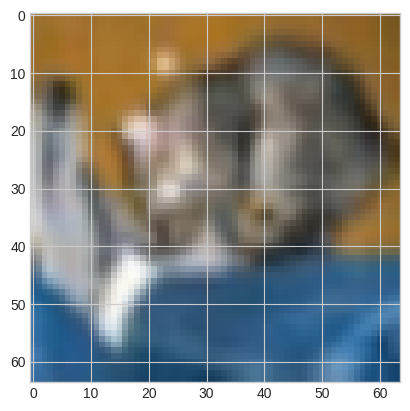

1/1 [==============================] - 0s 18ms/step
Classe predita: [7] rótulo: 8 Score:  0.43041515


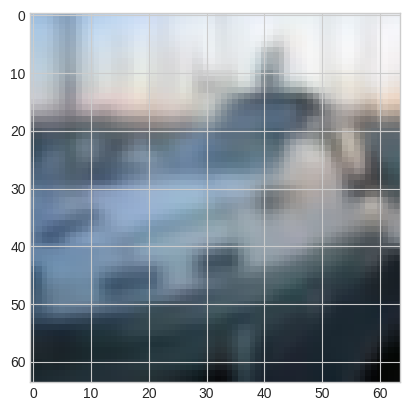

1/1 [==============================] - 0s 21ms/step
Classe predita: [8] rótulo: 0 Score:  0.4314493


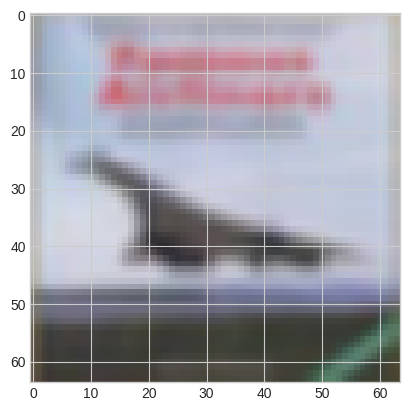

1/1 [==============================] - 0s 19ms/step
Classe predita: [7] rótulo: 1 Score:  0.69594234


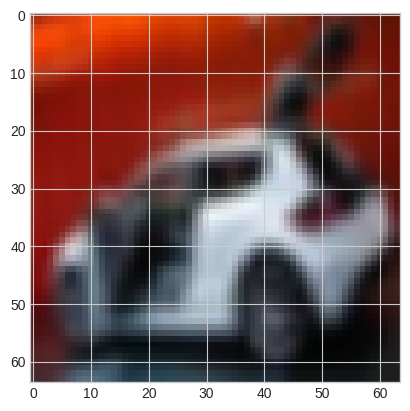

1/1 [==============================] - 0s 23ms/step
Classe predita: [0] rótulo: 6 Score:  0.38417828


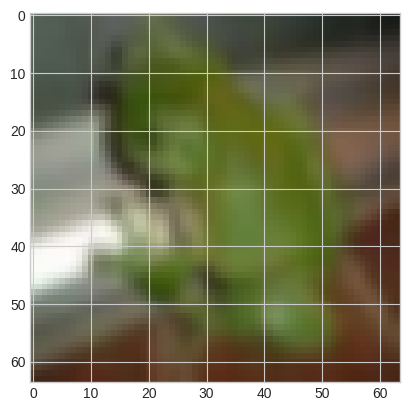

1/1 [==============================] - 0s 22ms/step
Classe predita: [7] rótulo: 3 Score:  0.45504895


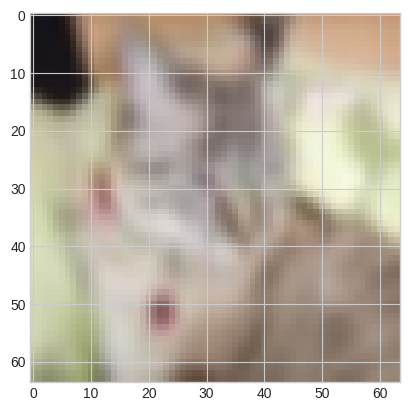

1/1 [==============================] - 0s 18ms/step
Classe predita: [6] rótulo: 1 Score:  0.52034914


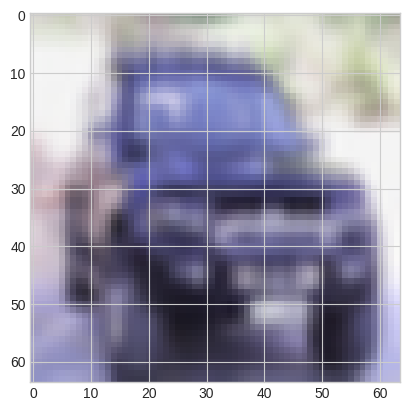

1/1 [==============================] - 0s 19ms/step
Classe predita: [6] rótulo: 8 Score:  0.71030504


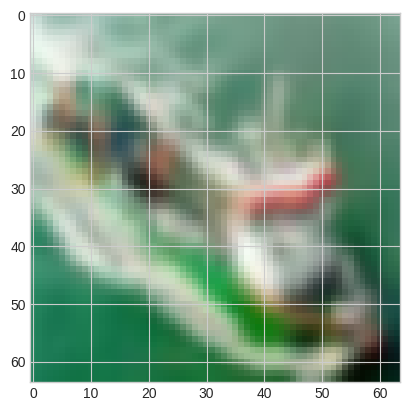

1/1 [==============================] - 0s 17ms/step
Classe predita: [5] rótulo: 7 Score:  0.36116847


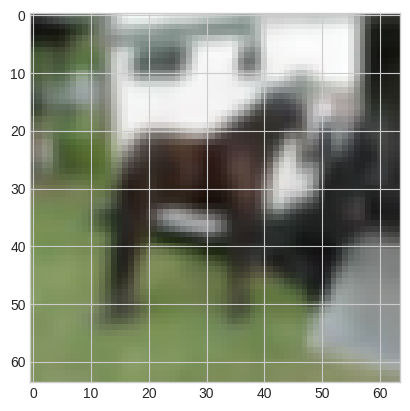

1/1 [==============================] - 0s 17ms/step
Classe predita: [4] rótulo: 5 Score:  0.75735766


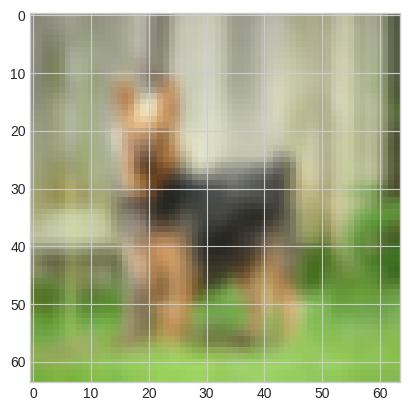

1/1 [==============================] - 0s 20ms/step
Classe predita: [3] rótulo: 2 Score:  0.34582692


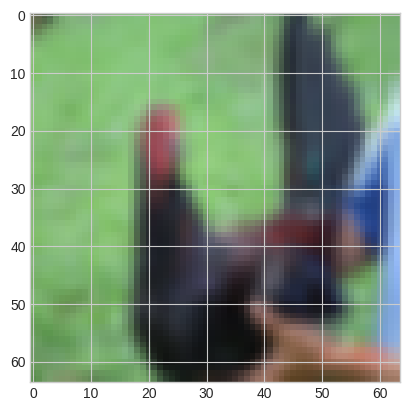

1/1 [==============================] - 0s 29ms/step
Classe predita: [3] rótulo: 4 Score:  0.6051394


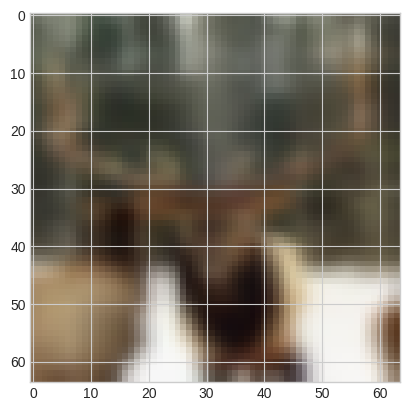

1/1 [==============================] - 0s 26ms/step
Classe predita: [3] rótulo: 5 Score:  0.71933573


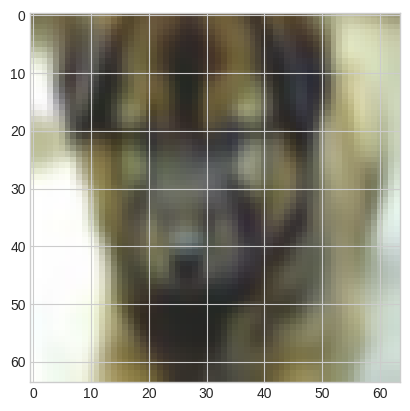

1/1 [==============================] - 0s 26ms/step
Classe predita: [3] rótulo: 2 Score:  0.48564094


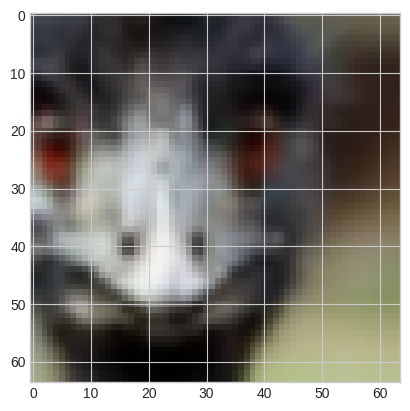

1/1 [==============================] - 0s 27ms/step
Classe predita: [7] rótulo: 4 Score:  0.9001229


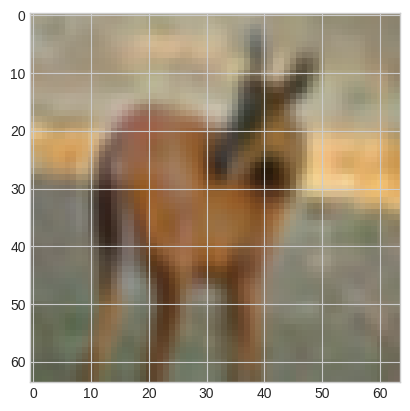

1/1 [==============================] - 0s 17ms/step
Classe predita: [7] rótulo: 5 Score:  0.7167898


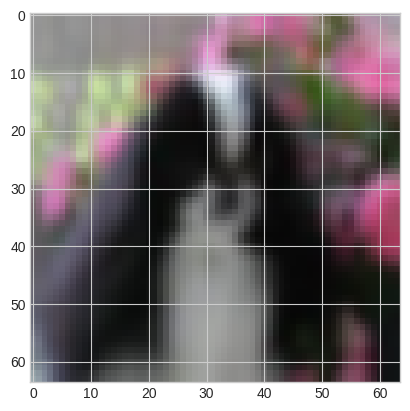

1/1 [==============================] - 0s 18ms/step
Classe predita: [3] rótulo: 6 Score:  0.41930288


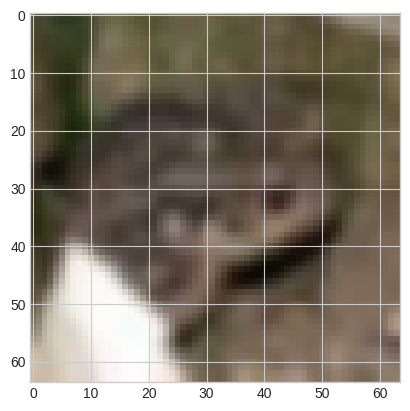

1/1 [==============================] - 0s 17ms/step
Classe predita: [3] rótulo: 9 Score:  0.6243541


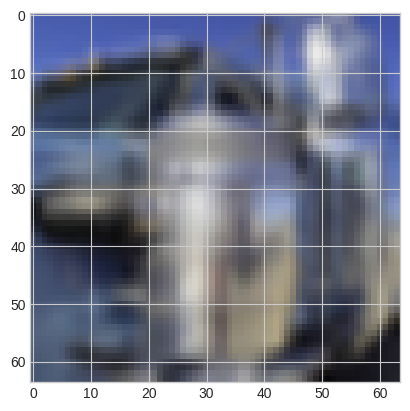

1/1 [==============================] - 0s 20ms/step
Classe predita: [4] rótulo: 6 Score:  0.60447335


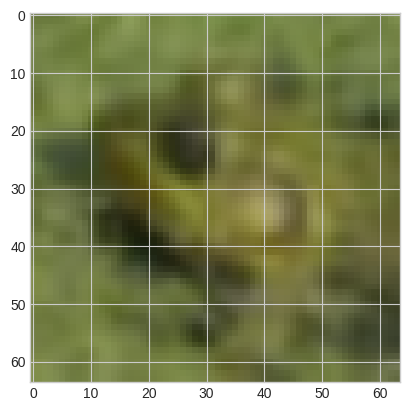

1/1 [==============================] - 0s 17ms/step
Classe predita: [5] rótulo: 7 Score:  0.56110436


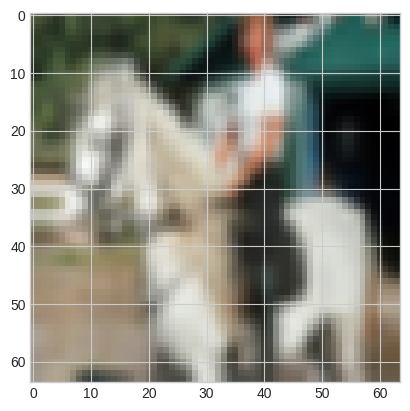

1/1 [==============================] - 0s 19ms/step
Classe predita: [5] rótulo: 7 Score:  0.7497022


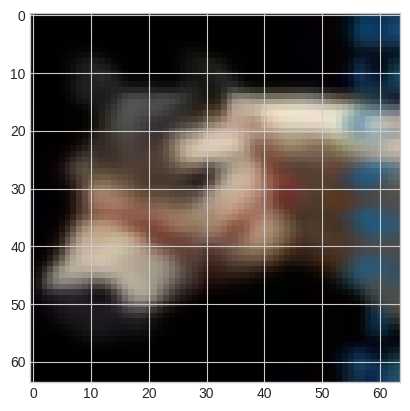

1/1 [==============================] - 0s 18ms/step
Classe predita: [5] rótulo: 4 Score:  0.380182


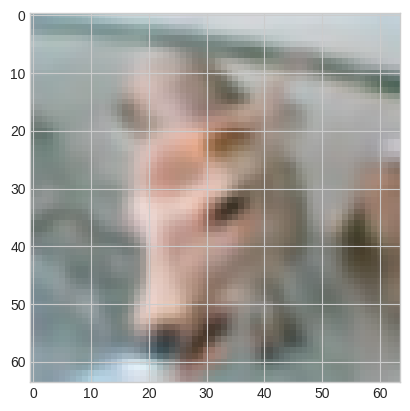

1/1 [==============================] - 0s 17ms/step
Classe predita: [3] rótulo: 6 Score:  0.5592668


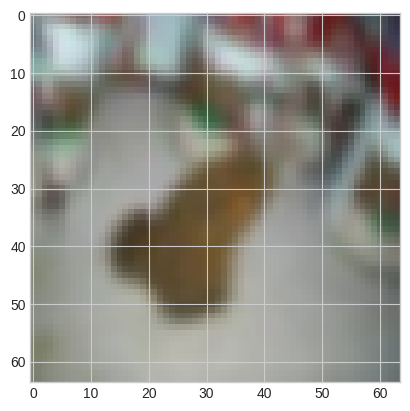

1/1 [==============================] - 0s 19ms/step
Classe predita: [4] rótulo: 6 Score:  0.72869563


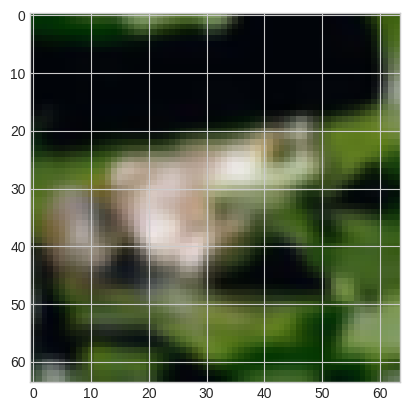

1/1 [==============================] - 0s 19ms/step
Classe predita: [6] rótulo: 2 Score:  0.54271656


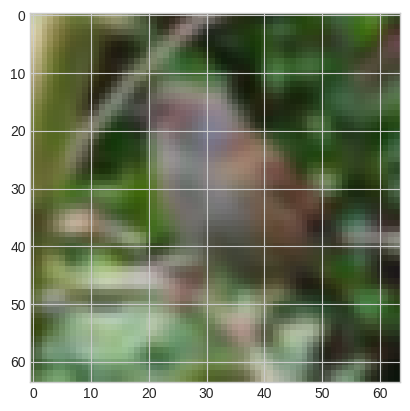

1/1 [==============================] - 0s 20ms/step
Classe predita: [8] rótulo: 1 Score:  0.8248727


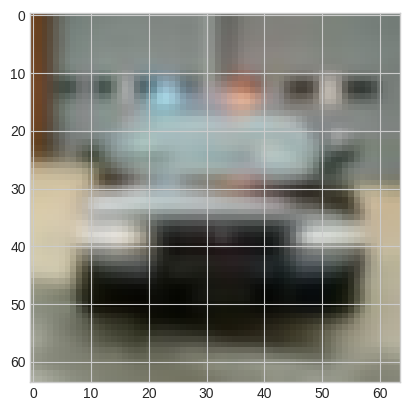

1/1 [==============================] - 0s 17ms/step
Classe predita: [3] rótulo: 6 Score:  0.37502766


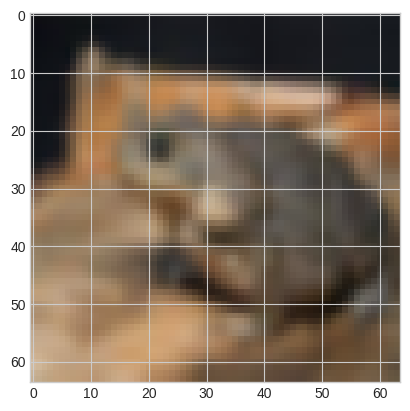

1/1 [==============================] - 0s 19ms/step
Classe predita: [9] rótulo: 0 Score:  0.6459415


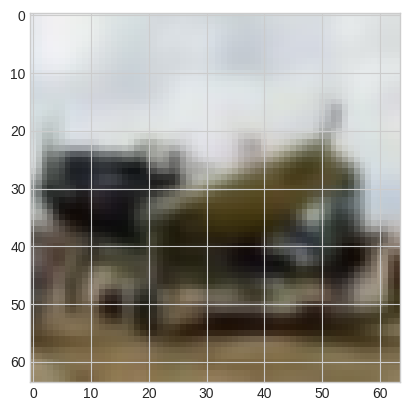

1/1 [==============================] - 0s 18ms/step
Classe predita: [0] rótulo: 9 Score:  0.9994117


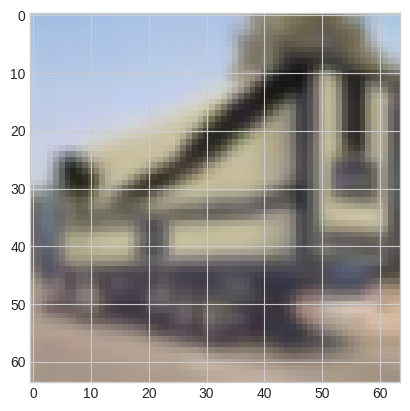

1/1 [==============================] - 0s 18ms/step
Classe predita: [5] rótulo: 3 Score:  0.8551116


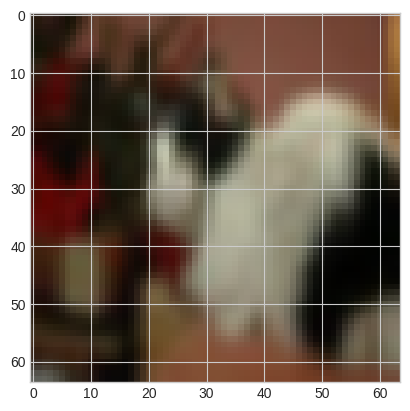

1/1 [==============================] - 0s 18ms/step
Classe predita: [7] rótulo: 5 Score:  0.831598


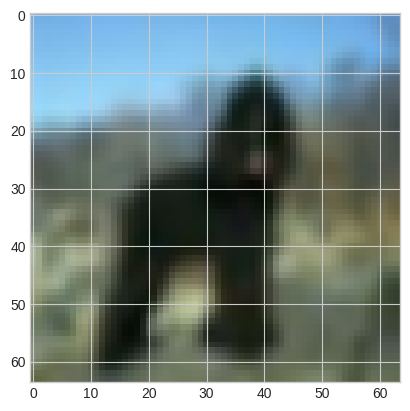

1/1 [==============================] - 0s 19ms/step
Classe predita: [5] rótulo: 2 Score:  0.4020018


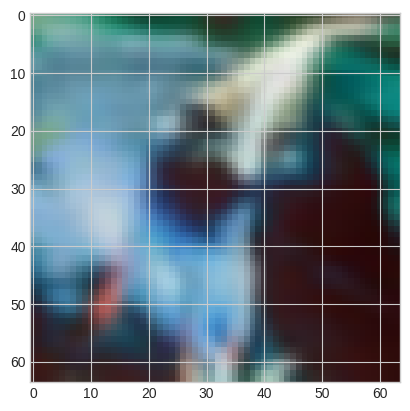

1/1 [==============================] - 0s 19ms/step
Classe predita: [4] rótulo: 7 Score:  0.5893004


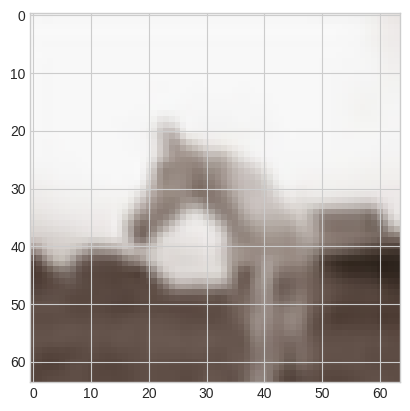

1/1 [==============================] - 0s 17ms/step
Classe predita: [2] rótulo: 0 Score:  0.58462256


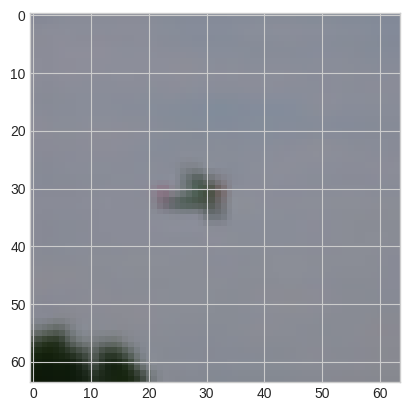

1/1 [==============================] - 0s 18ms/step
Classe predita: [7] rótulo: 4 Score:  0.89116764


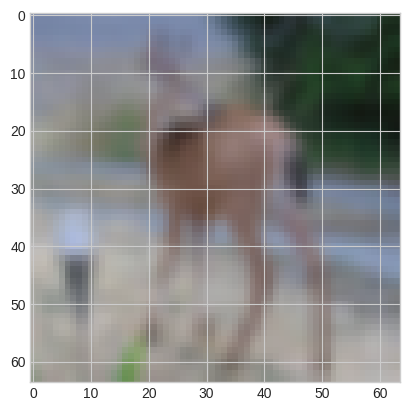

1/1 [==============================] - 0s 18ms/step
Classe predita: [2] rótulo: 6 Score:  0.85989505


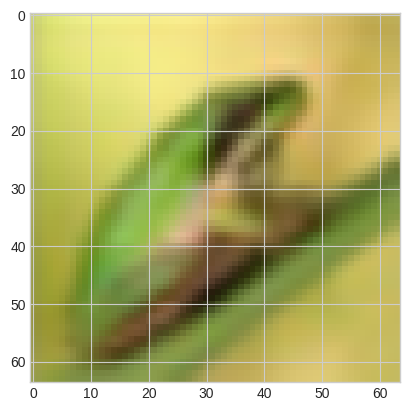

1/1 [==============================] - 0s 19ms/step
Classe predita: [5] rótulo: 7 Score:  0.5921849


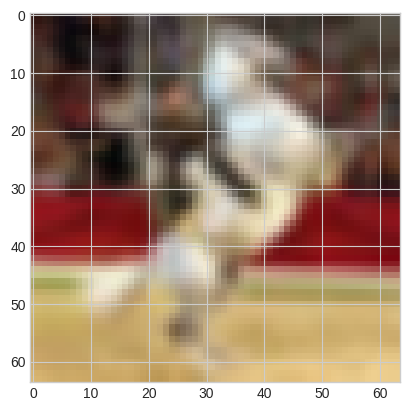

1/1 [==============================] - 0s 20ms/step
Classe predita: [7] rótulo: 3 Score:  0.38761353


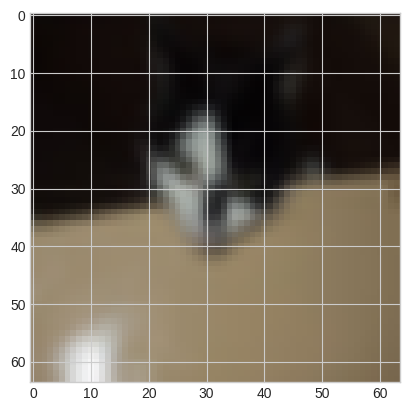

1/1 [==============================] - 0s 23ms/step
Classe predita: [2] rótulo: 0 Score:  0.46880907


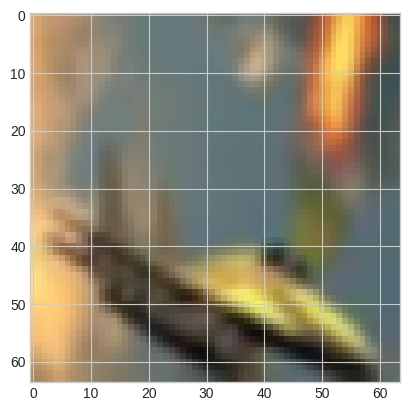

1/1 [==============================] - 0s 26ms/step
Classe predita: [4] rótulo: 2 Score:  0.7199792


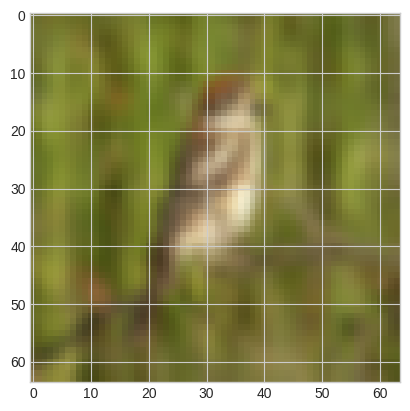

1/1 [==============================] - 0s 35ms/step
Classe predita: [1] rótulo: 9 Score:  0.9351275


KeyboardInterrupt: ignored

In [19]:
# Plotando os erros do modelo carregado
from matplotlib import pyplot as plt

rotulos=np.argmax(testY, axis=1)

for i in range(len(testX)):
  exemplo=testX[i]
  exemplo = exemplo.reshape(1, W, H, 3)
  saida=cnn_model.predict(exemplo)
  classe=np.argmax(saida, axis=1)
  if (classe == rotulos[i]):
    continue
  print("Classe predita:", classe, "rótulo:", rotulos[i], "Score: ", np.max(saida))
  exemplo = exemplo.reshape(W, H, 3)
  plt.imshow(exemplo, interpolation='nearest')
  plt.show()

